#Predicting Taxi Fare Prices in New York City

**Objective**

The goal of this project is to predict the price of a taxi ride in New York City based on key trip characteristics such as distance, time, and passenger count.

By developing a predictive model, new and existing businesses in the ride-sharing and taxi industry can gain valuable insights into what factors most strongly influence fare prices. This understanding can support smarter decisions in areas like fleet management, dynamic pricing, and customer service optimization.

The dataset used for this analysis is from Kaggle’s “New York City Taxi Fare Prediction” competition, available at:
🔗 https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data


Since the original dataset is more than 5 GB, processing the full file would be computationally expensive. Therefore, this study focuses on a subset containing data from the year 2015, which provides a representative sample while keeping the analysis manageable.

Code used to split the file.

<div style="border: 2px solid blue; padding: 10px; border-radius: 5px; background-color: #f0f8ff;">

        import dask.dataframe as dd

        df = dd.read_csv("~/Capstone/new-york-city-taxi-fare-prediction/train.csv", assume_missing=True)


        df['pickup_datetime'] = dd.to_datetime(df['pickup_datetime'])
        df['year'] = df['pickup_datetime'].dt.year

        for year in df['year'].unique().compute():
            print(year)
            df_year = df[df['year'] == year]
            df_year.to_csv(f"uber_data_{year}/uber_data_{year}.csv", index=False, single_file=True)

</div>

#### The project follows a structured ML pipeline, including:

-# [1. Data Loading]
-# [2. Exploratory Data Analysis]
-# [3. Train/Test split]
-# [4. Feature Engineering]
-# [5. Regression Modeling]
-# [6. Hyperparameter tuning]
- #[7. Selecting best model](#7)
-# [8. Model interpretation]
-# [9. Results]

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=ConvergenceWarning)

# [1. Data Loading](#1-data-loading)

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [5]:
df = pd.read_csv("~/Capstone/new-york-city-taxi-fare-prediction/taxi_fare_data_2015.csv", parse_dates=["pickup_datetime"],nrows=500000)

#### Data dictionary - New York Taxi Data

|  Name  | Description  |  Type |
|:-------------:|:-------------:|:-----------:|
| **Id**  | Unique value to identify each row. Comprised of pickup_datetime plus a unique integer .  | *String* |
| **Pickup Datetime**  | Time at which the ride started.  | *Timestamp* |
| **Pickup Longtitude**  | Longtitude of the pickup location.  | *Float* |
| **Pickup Latitude**  | Latitude of the pickup location.  | *Float* |
| **Dropoff Longtitude**  | Longtitude of the dropoff location.  | *Float* |
| **Dropoff Latitude**  | Latitude of the dropoff location.  | *Float* |
| **Passenger Count**  | Number of passenger(s).  | *Float* |
| **Year**  | Year of the ride.  | *Integer* |


In [7]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year
0,2015-06-21 21:46:34.0000001,22.54,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,1.0,2015
1,2015-01-11 03:15:38.0000001,58.00,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,40.847225,1.0,2015
2,2015-03-12 08:08:38.0000001,4.50,2015-03-12 08:08:38+00:00,-73.990173,40.756447,-73.985619,40.762829,1.0,2015
3,2015-04-12 10:19:05.0000001,11.50,2015-04-12 10:19:05+00:00,-73.979279,40.723438,-74.004608,40.746948,6.0,2015
4,2015-05-12 23:51:42.0000007,5.00,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0,2015


In [8]:
#Check for records with Null values
df.isna().sum().sum()

0

# 2. Exploratory Data Analysis <a id="2"></a>

In [10]:
print("Number of rows and columns in the dataset")
print(df.shape)

Number of rows and columns in the dataset
(500000, 9)


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                500000 non-null  object             
 1   fare_amount        500000 non-null  float64            
 2   pickup_datetime    500000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   500000 non-null  float64            
 4   pickup_latitude    500000 non-null  float64            
 5   dropoff_longitude  500000 non-null  float64            
 6   dropoff_latitude   500000 non-null  float64            
 7   passenger_count    500000 non-null  float64            
 8   year               500000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 34.3+ MB


In [12]:
print("Descriptive statistics of numerical variables:")
df.describe()


Descriptive statistics of numerical variables:


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0
mean,12.991517,-72.710829,40.054869,-72.746399,40.075335,1.680326,2015.0
std,11.875002,9.585400,5.280169,9.449748,5.206106,1.337461,0.0
min,-100.000000,-121.915237,0.000000,-121.915237,0.000000,0.000000,2015.0
25%,6.500000,-73.991844,40.735516,-73.991241,40.734188,1.000000,2015.0
50%,9.500000,-73.981590,40.752995,-73.979607,40.753643,1.000000,2015.0
75%,14.500000,-73.966431,40.767773,-73.962120,40.768909,2.000000,2015.0
max,1273.310000,0.000000,46.209961,0.000000,46.560928,9.000000,2015.0


**Observation**
* As the features like dropoff/pickup latitude and longtitude in this dataset doesn't represent any numerical value though it is a Integer. Further processing is needed to derive inferable data based on the given features to arrive at any conclusion.





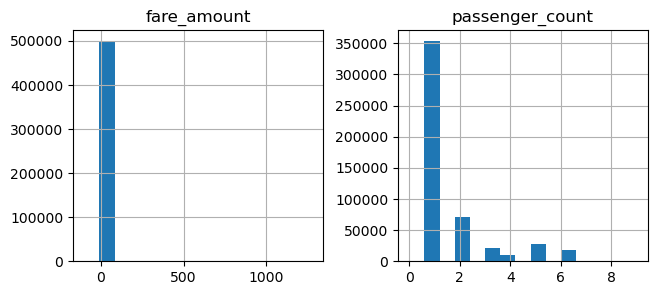

In [14]:
# Histograms for numerical variables
df_numeric = df.drop(columns=["key", "pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","year"])
df_numeric.hist(bins=15, figsize=(20, 3), layout=(1, 5))
plt.show()

## Insight on numeric features histogram
* Fare amount - Most data is concentrated in less than 1000$, but have values spread till 80000.
* Passenger Count - Most of the passengers travelled alone or the second highest passenger count to take a taxi is 2 people.

**Feature Transformations based on the features available**

In [17]:
# Cleaning up Latitude and Longtitude. Valid values for latitude is between (-90 and  90) and longitude is (-180 and 180).

df=df[(df['pickup_latitude'] >= -90)&( df['pickup_latitude'] <= 90)&(df['pickup_longitude'] >= -180)&( df['pickup_longitude'] <= 180)]
df=df[(df['dropoff_latitude'] >= -90)&( df['dropoff_latitude'] <= 90)&(df['dropoff_longitude'] >= -180)&( df['dropoff_longitude'] <= 180)]

In [18]:
#Dropping records with Passenger count as zero
df=df[df['passenger_count']>=1]

In [19]:
# Dropping records where fare amount is less than 2 and greater than 65.
df = df[(df['fare_amount'] > 2) & (df['fare_amount'] <= 65)]

In [20]:
# Calculating distance based on the given Pickup/Dropoff latitude and longtitude.
from geopy.distance import geodesic

df['trip_distance_mile'] = [
    geodesic((lat1, lon1), (lat2, lon2)).miles
    for lat1, lon1, lat2, lon2 in zip(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
]

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,trip_distance_mile
0,2015-06-21 21:46:34.0000001,22.54,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,1.0,2015,4.161446
1,2015-01-11 03:15:38.0000001,58.00,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,40.847225,1.0,2015,7.935389
2,2015-03-12 08:08:38.0000001,4.50,2015-03-12 08:08:38+00:00,-73.990173,40.756447,-73.985619,40.762829,1.0,2015,0.501041
3,2015-04-12 10:19:05.0000001,11.50,2015-04-12 10:19:05+00:00,-73.979279,40.723438,-74.004608,40.746948,6.0,2015,2.097438
4,2015-05-12 23:51:42.0000007,5.00,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0,2015,0.520029


In [21]:
#Records dropped where Trip distance is less 1 mile and greater than 50 as they are outliers .
df = df[(df['trip_distance_mile']>=1 ) & (df['trip_distance_mile']<=50 )]

In [22]:
# Remove trips with non-positive distances or fares
df = df[(df["trip_distance_mile"] > 0) & (df["fare_amount"] > 0)]

In [23]:
df["fare_per_mile"] = df["fare_amount"] / df["trip_distance_mile"]

# Keeping data where the fare amount is in a reasonable range, e.g. $2–$10 per mile
df = df[(df["fare_per_mile"] >= 2) & (df["fare_per_mile"] <= 10)]

In [24]:
#Adding more features to derive a better understanding of other factors which has an impact on the price
#Columns like hour,week,weekday added for deriving features like is_night,is_rush_hour etc
df['hour'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month_name()
df['week'] = df['pickup_datetime'].dt.isocalendar().week
df['is_night'] = ((df['hour'] >= 21) | (df['hour'] < 6)).astype(int)
df['weekday'] = df['pickup_datetime'].dt.weekday
df['is_weekend'] = ((df["weekday"] >=5) &(df["weekday"] <=6)).astype(int)
df['is_rush_hour'] = df['hour'].apply(lambda x:1 if x >= 7 and x <= 10 or x >= 16 and x <= 19 else 0)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296024 entries, 0 to 499999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   key                 296024 non-null  object             
 1   fare_amount         296024 non-null  float64            
 2   pickup_datetime     296024 non-null  datetime64[ns, UTC]
 3   pickup_longitude    296024 non-null  float64            
 4   pickup_latitude     296024 non-null  float64            
 5   dropoff_longitude   296024 non-null  float64            
 6   dropoff_latitude    296024 non-null  float64            
 7   passenger_count     296024 non-null  float64            
 8   year                296024 non-null  int64              
 9   trip_distance_mile  296024 non-null  float64            
 10  fare_per_mile       296024 non-null  float64            
 11  hour                296024 non-null  int32              
 12  month               2

In [26]:
# Columns needed for further processing moved into a new dataframe.
taxi_df = df.drop(columns=['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','weekday','hour','week','fare_per_mile','year'],axis=1)

In [27]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296024 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         296024 non-null  float64
 1   passenger_count     296024 non-null  float64
 2   trip_distance_mile  296024 non-null  float64
 3   month               296024 non-null  object 
 4   is_night            296024 non-null  int64  
 5   is_weekend          296024 non-null  int64  
 6   is_rush_hour        296024 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 18.1+ MB


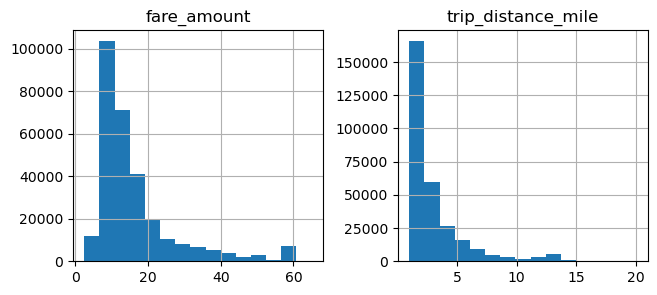

In [28]:
# Histograms for numerical variables
taxi_df_num = taxi_df.drop(columns=["passenger_count","month","is_night","is_weekend","is_rush_hour"])
taxi_df_num.hist(bins=15, figsize=(20, 3), layout=(1, 5))
plt.show()


**Insights based on the above histograms**
**Fare Amount Distribution**
  * Most fares are between`( 0$ -20$ )` and very few trip have fares upto `60$`+.
  * Our target fare amount has a right-skewed distribution.
**Trip Distance Distribution**
  * Most of the trips are less than 3 miles.
  * Trip distance has a right-skewed distribution as expected, as the long-distance rides in the city are a rare occurrence.

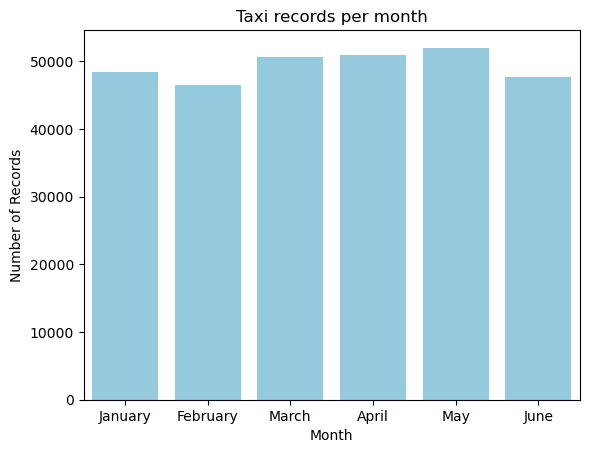

In [30]:
# Bar plot for Month
temp = taxi_df[['month']]
temp=temp.copy()
temp['month']= pd.Categorical(
    taxi_df["month"],
    categories=list(calendar.month_name[1:7]),  # Jan → Dec
    ordered=True
)
rec_count = temp["month"].value_counts().sort_index()  # sorted by month
sns.barplot(x=rec_count.index, y=rec_count.values, color="skyblue")
plt.xlabel("Month")
plt.ylabel("Number of Records")
plt.title("Taxi records per month")
plt.show()

#### Insights for Taxi data based on Month

    - Each month shows around 45,000 to 52,000 taxi records. shows that taxi service operated without major fluctuations across months.
    - From January to May, the rides show a slight increase every month, possibly due to seasonal factors.
    - Number of rides shows maximum spike in May, this could reflect increased travel activity in spring or better data availability.

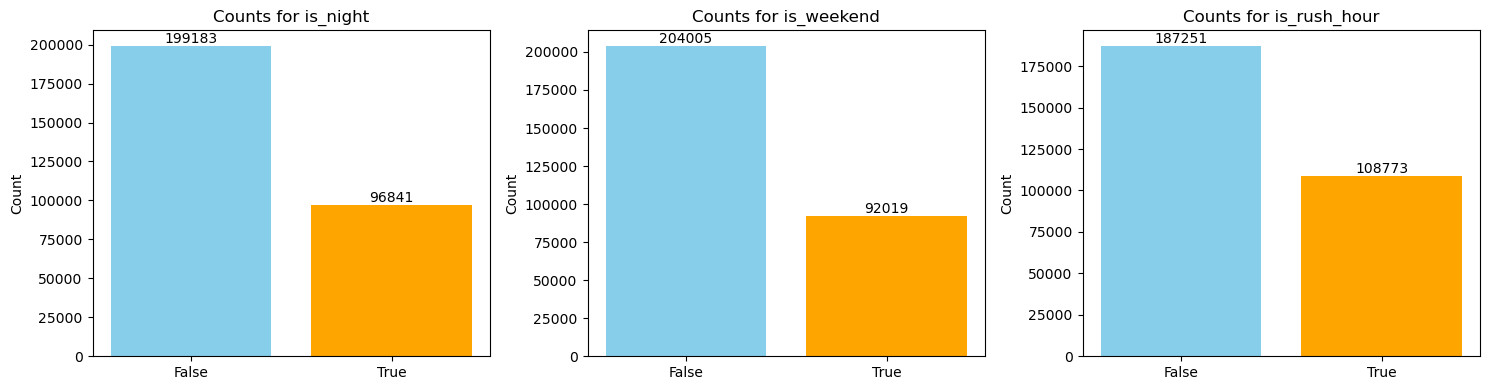

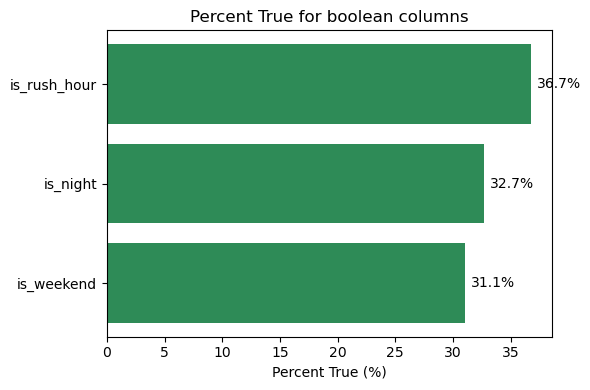

In [32]:
# ---------------------------
# Detect boolean columns
# ---------------------------
bool_cols = [c for c in taxi_df.columns if taxi_df[c].dropna().isin([0,1,True,False]).all()]

# Make sure 0/1 are cast to bool
for c in bool_cols:
    taxi_df[c] = taxi_df[c].astype(bool)

# Set up subplots: 1 row, N columns
fig, axes = plt.subplots(1, len(bool_cols), figsize=(5*len(bool_cols), 4))

if len(bool_cols) == 1:
    axes = [axes]  # make iterable if only one column

for ax, c in zip(axes, bool_cols):
    counts = taxi_df[c].value_counts().sort_index()  # False, True
    ax.bar(['False', 'True'], counts.values, color=["skyblue", "orange"])
    ax.set_title(f'Counts for {c}')
    ax.set_ylabel('Count')

    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

# ---------------------------
# 2) Percent True for each boolean column
# ---------------------------
percent_true = taxi_df[bool_cols].mean().sort_values() * 100

plt.figure(figsize=(6,4))
plt.barh(percent_true.index, percent_true.values, color="seagreen")
plt.xlabel('Percent True (%)')
plt.title('Percent True for boolean columns')

for i, v in enumerate(percent_true.values):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.tight_layout()
plt.show()


#### Insights on Boolean bar charts. 
* Majority of trips happened during Daytime, Non-rush hour, and weekdays. which points to work-related short urban rides.
* Night and weekend trips still substantial, which is almost 30-40% of the data, likely related to leisure or social travel.
* Above factors could be important predictors,since fares often depend on these features.

In [34]:
# As the Target value is heavily right-skewed. Stablizing the data for the ML model to understand better.
taxi_df['fare_amount'] = np.log1p(taxi_df['fare_amount'])

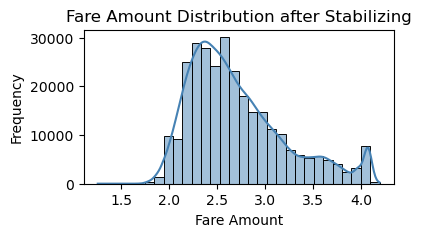

In [35]:
# After stablizing.

plt.figure(figsize=(4, 2))
sns.histplot(taxi_df['fare_amount'], kde=True, bins=30, color="steelblue")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Fare Amount Distribution after Stabilizing")
plt.show()


#### Insight after log trabsformation of Fare amount
- After applying a log transformation, the fare amount distribution became approximately normal.
- This reduces skewness, minimizes the influence of extreme fares, and enhances the reliability and accuracy of predictive models.

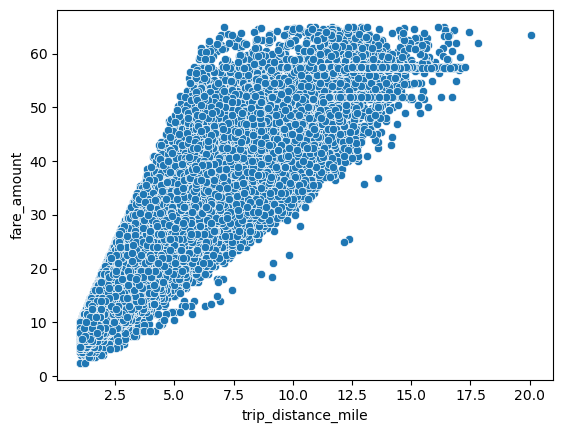

In [37]:
sns.scatterplot(x=df['trip_distance_mile'],y=df['fare_amount']) ;

#### Trip Distance vs Fare Amount – Insight

- The analysis confirms a clear positive relationship between trip distance and fare amount, indicating that longer trips consistently generate higher fares.
- The triangular pattern shows that fares can vary for trips of the same distance, likely because of factors like traffic, tolls, or changes in pricing during busy times.
- A few anomalies with unusually high fares may reflect data inconsistencies or exceptional ride conditions.

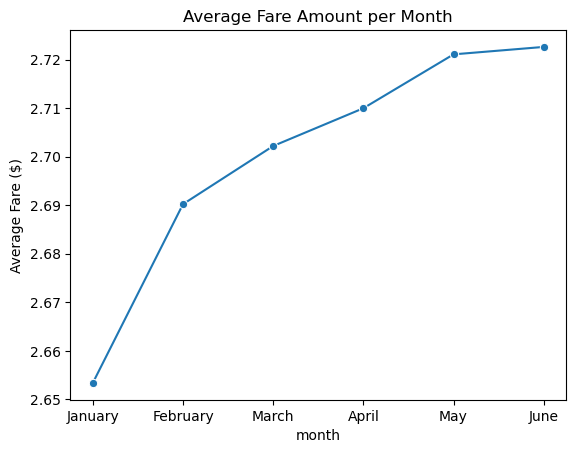

In [39]:
# Group by year and compute mean fare

temp = taxi_df.groupby("month", observed=True)["fare_amount"].mean().reset_index()
temp["month"] = pd.Categorical(
    temp["month"],
    categories=list(calendar.month_name[1:]),  # Jan → Dec
    ordered=True
)
sns.lineplot(data=temp, x="month", y="fare_amount", marker="o")
plt.title("Average Fare Amount per Month")
plt.ylabel("Average Fare ($)")
plt.show()

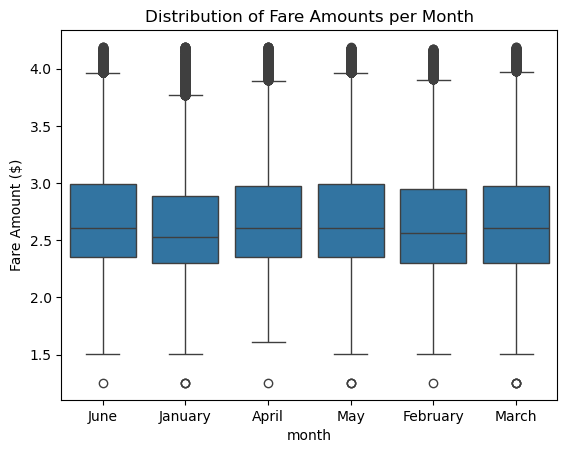

In [40]:
sns.boxplot(data=taxi_df, x="month", y="fare_amount")
plt.title("Distribution of Fare Amounts per Month")
plt.ylabel("Fare Amount ($)")
plt.show()

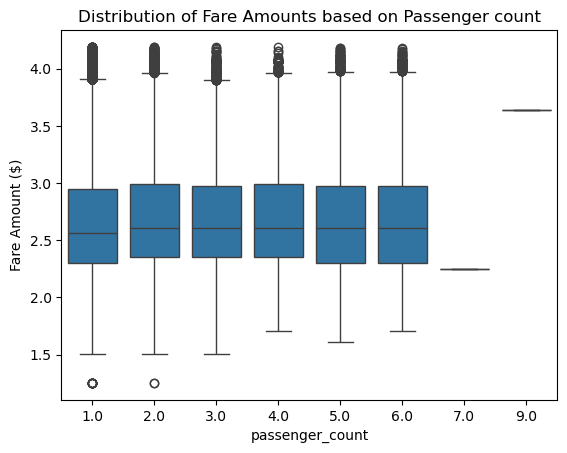

In [41]:
sns.boxplot(data=taxi_df, x="passenger_count", y="fare_amount")
plt.title("Distribution of Fare Amounts based on Passenger count")
plt.ylabel("Fare Amount ($)")
plt.show()

# 3. Train/Test split <a id="3"></a>

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

In [44]:
X= taxi_df.drop(columns=["fare_amount"],axis=1)
y=taxi_df["fare_amount"]

In [45]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3, random_state=42)

In [46]:
print(f"Training set size: {X_train.shape}. Training labels size: {y_train.shape}")
print(f"Test set size: {X_test.shape}. Test labels size: {y_test.shape}")

Training set size: (207216, 6). Training labels size: (207216,)
Test set size: (88808, 6). Test labels size: (88808,)


# 4. Feature Engineering <a id="4"></a>

In [48]:
from sklearn.compose import ColumnTransformer

In [49]:
# Define column groups

cat_cols = ["month"]
num_cols = ["passenger_count","trip_distance_mile"]
bool_cols = ["is_rush_hour","is_night","is_weekend"]

In [50]:
# Preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        ("num", StandardScaler(), num_cols),
        ("bool", "passthrough", bool_cols)
    ]
)

# 5. Regression Modeling <a id="5"></a>

In [73]:
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

In [53]:

results_df = pd.DataFrame(columns=['Model', 'Train RMSE','Train R2', 'Test RMSE','Test R2'])

In [54]:

results_hyperparameter=[]
def model_results(model,model_name,X_train,y_train,X_test,y_test,is_grid):
    
    model.fit(X_train,y_train)

    trained_models[name] = model
    
    if is_grid=='Y' :
        best_model = gs.best_estimator_
        train_pred_log = best_model.predict(X_train)
        test_pred_log = best_model.predict(X_test)
    else :
        train_pred_log = model.predict(X_train)
        test_pred_log =model.predict(X_test)
    
    train_pred =  np.expm1(train_pred_log)
    test_pred = np.expm1(test_pred_log)

    y_train_org =np.expm1(y_train)
    y_test_org = np.expm1(y_test)

    
    train_mse = mean_squared_error(y_train_org,train_pred)
    test_mse = mean_squared_error(y_test_org,test_pred)
    
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    
    train_r2 =r2_score(y_train_org,train_pred)
    test_r2 =r2_score(y_test_org,test_pred)

    if is_grid=='N' :
        results_df.loc[len(results_df)] = [model_name,  train_rmse,train_r2, test_rmse,  test_r2] ;
    else:
        results_hyperparameter.append({
            "Model": name,
            "Best Params": model.best_params_,
            "RMSE Train": train_rmse,
            "R² Train": train_r2,
            "RMSE Test": test_rmse,
            "R² Test": test_r2
        })


In [55]:
print(type(X_train))
print(X_train.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['passenger_count', 'trip_distance_mile', 'month', 'is_night',
       'is_weekend', 'is_rush_hour'],
      dtype='object')


### Baseline RMSE & R2 scores

In [57]:
y_train_org =np.expm1(y_train)
y_test_org = np.expm1(y_test)
y_mean_pred = np.full_like(y_test_org, y_train_org.mean())  # Predicting the mean for all test samples
rmse_baseline = np.sqrt(mean_squared_error(y_test_org, y_mean_pred))
r2_baseline = r2_score(y_test_org, y_mean_pred)

print(f"Baseline RMSE: {rmse_baseline}")
print(f"Baseline R²: {r2_baseline}")

Baseline RMSE: 11.317023679468548
Baseline R²: -5.415426951316249e-08


#### Basic Models

In [59]:
#Linear Regression
lr_pipe= Pipeline([("preprocessing",preprocessor),
                   ("lr",LinearRegression())])
# Ridge Regression
ridge_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("ridge", Ridge(alpha=1.0))
])

# Lasso Regression
lasso_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("lasso", Lasso(alpha=0.01))
])

# Random Forest
rf_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# XGBoost
xgb_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("xgb", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])



In [60]:
models = {
    "LinearRegression": lr_pipe,
    "Ridge": ridge_pipe,
    "Lasso": lasso_pipe,
    "RandomForest": rf_pipe,
    "XGBoost": xgb_pipe
}
trained_models = {}
for name, model in models.items():
    print(f'Training {name}...')
    model_results(model,name,X_train,y_train,X_test,y_test,'N')
    

results_df

Training LinearRegression...
Training Ridge...
Training Lasso...
Training RandomForest...
Training XGBoost...


,Model,Train RMSE,Train R2,Test RMSE,Test R2
0,LinearRegression,7.394074,0.572780,7.325965,0.580951
1,Ridge,7.393965,0.572792,7.325858,0.580963
2,Lasso,6.889272,0.629122,6.819746,0.636862
3,RandomForest,1.407059,0.984529,3.662430,0.895269
4,XGBoost,3.299120,0.914949,3.328653,0.913489


#### Observation based on Model performace

- Tree-based models (Random Forest and XGBoost) significantly outperform linear models, capturing complex, nonlinear relationships between trip features and fare amount.

- XGBoost model performs the best with the lowest test RMSE (3.33) and highest test R² (0.913), indicating strong predictive accuracy and stability.

- Random Forest performs exceptionally on training data but shows mild overfitting (large gap between train and test RMSE).

- Linear and Ridge regressions provide consistent but less accurate results, suggesting they fail to capture nonlinear effects.

Lasso regression improves slightly due to its feature selection effect but still underperforms compared to ensemble models.

Business Insight

Advanced ensemble methods like XGBoost provide the most reliable fare predictions, making them suitable for real-world applications such as dynamic fare estimation, demand forecasting, and fleet optimization in ride-hailing operations.

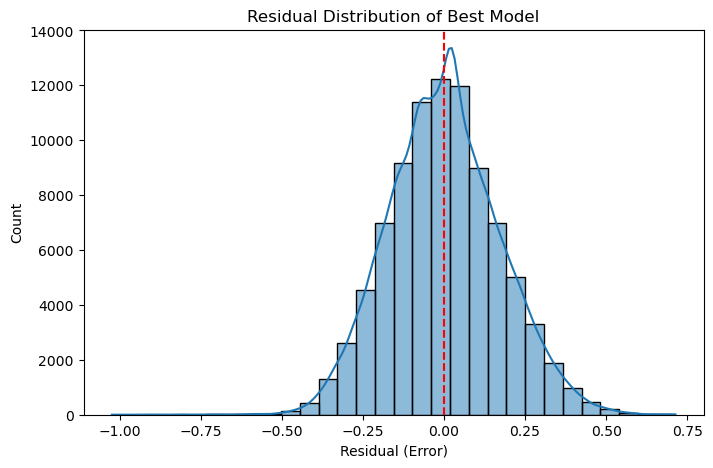

In [62]:
# Get the row with the lowest Test RMSE
best_row = results_df.loc[results_df["Test RMSE"].idxmin()]

# Extract best model name
best_model_name = best_row["Model"]

y_pred_best = trained_models[best_model_name].predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual (Error)")
plt.title("Residual Distribution of Best Model")
plt.show()

 If residuals are centered around 0 and normally distributed, the model is working well even if R² is low. 
    - Centered around 0 means that the model isn't systematically overpredicting or underpredicting. 
    - Bell shaped means errors are random and normally distributed. 
    
In other words, the model is making errors, but they are expected and random rather than systematic.

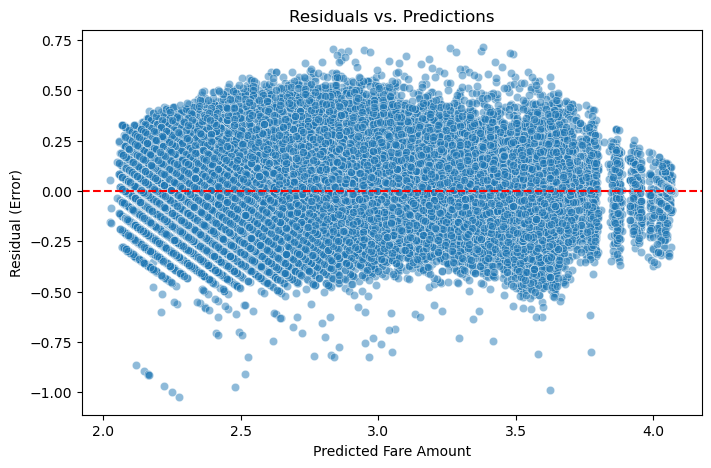

In [64]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Fare Amount")
plt.ylabel("Residual (Error)")
plt.title("Residuals vs. Predictions")
plt.show()

The residual analysis suggests that our XGBoost model is performing well, with errors normally distributed and centered around zero, indicating no systematic bias. The residuals are randomly scattered in the residuals vs. predictions plot, showing that the model captures the relationship well without obvious heteroskedasticity or missing patterns. While some outliers exist, they are relatively few and may represent special cases. Overall, the model appears well-calibrated and reliable, though further investigation into outliers could provide additional insights.

# 6. Hyperparameter tuning <a id="6"></a>

In [67]:

lasso_model = trained_models["Lasso"]
feature_names = lasso_model.named_steps["preprocessing"].get_feature_names_out()
lasso_coefficients = pd.DataFrame(lasso_model.named_steps["lasso"].coef_, index=feature_names, columns=['Lasso Coefficient']).sort_values(['Lasso Coefficient'], key=abs, ascending=False)

lasso_coefficients

,Lasso Coefficient
num__trip_distance_mile,0.441427
bool__is_night,-0.009356
cat__month_April,0.000000
cat__month_February,0.000000
cat__month_January,-0.000000
cat__month_June,0.000000
cat__month_March,0.000000
cat__month_May,0.000000
num__passenger_count,0.000000
bool__is_rush_hour,0.000000


In [68]:

models = {
    "Grid_LinearRegression": {
        "model": LinearRegression(),
        "params": {}  # no hyperparameters
    },
    "Grid_Ridge": {
        "model": Ridge(),
        "params": {"model__alpha": [0.01, 0.1, 1, 10, 100]}
    },
    "Grid_Lasso": {
        "model": Lasso(max_iter=5000),
        "params": {"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
    },
    "Grid_RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "model__n_estimators": [100,200],
            "model__max_depth": [5, 10, None],
            "model__min_samples_split": [2, 5]
        }
    },
    "Grid_XGBoost": {
        "model": XGBRegressor(random_state=42, objective="reg:squarederror"),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 5, 7],
            "model__learning_rate": [0.01, 0.1, 0.2]
        }
    }
    
}


results = {}

for name, cfg in models.items():
    print(f"Training {name}...")
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', cfg["model"])])

    gs = GridSearchCV(pipe,
                      cfg["params"],
                      cv=5,
                      scoring="neg_mean_squared_error",
                      n_jobs=-1)
    
    model_results(gs,name,X_train,y_train,X_test,y_test,'Y')



    results[name] = {
        "Best Params": gs.best_params_,
        "Train Score": -gs.best_score_
    }

results_hyp_df = pd.DataFrame(results_hyperparameter)



Training Grid_LinearRegression...
Training Grid_Ridge...
Training Grid_Lasso...
Training Grid_RandomForest...
Training Grid_XGBoost...


In [69]:
pd.set_option('display.max_colwidth', None) 
results_hyp_df.sort_values(['RMSE Test', 'R² Test'], ascending=[True,False])

,Model,Best Params,RMSE Train,R² Train,RMSE Test,R² Test
4,Grid_XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}",3.310165,0.914378,3.327455,0.913551
3,Grid_RandomForest,"{'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}",3.236641,0.918140,3.333945,0.913213
2,Grid_Lasso,{'model__alpha': 0.001},7.338536,0.579173,7.270659,0.587254
1,Grid_Ridge,{'model__alpha': 10},7.392985,0.572905,7.324895,0.581073
0,Grid_LinearRegression,{},7.394074,0.572780,7.325965,0.580951


* All of our top models exhibit very similar performance metrics, suggesting that their rankings may vary with different data splits. We will choose XGBoost with hyperparameters {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}.

# 7. Selecting best model <a id="7"></a>

In [75]:
best_model = xgb_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("xgb", XGBRegressor(learning_rate= 0.1, max_depth=5, n_estimators=100))
])
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse_train = np.sqrt(-cross_val_score(best_model, X_train, y_train_org, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1))
cv_r2_train = cross_val_score(best_model, X_train, y_train_org, scoring="r2", cv=cv, n_jobs=-1)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_org= np.expm1(y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_org, y_pred_org))
r2_test = r2_score(y_test_org, y_pred_org)
    
BestModelResults = {
        "Model": "XGBoost", 
        "RMSE train (CV Mean)": np.mean(cv_rmse_train), 
        "R² Score train (CV Mean)": np.mean(cv_r2_train),
        "RMSE test": rmse_test, 
        "R² Score test": r2_test
    }

BestModelResults

{'Model': 'XGBoost',
 'RMSE train (CV Mean)': 3.3110494947631723,
 'R² Score train (CV Mean)': 0.9143093302770884,
 'RMSE test': 3.327454784964227,
 'R² Score test': 0.9135510147361663}

# 8. Model interpretation <a id="8"></a>

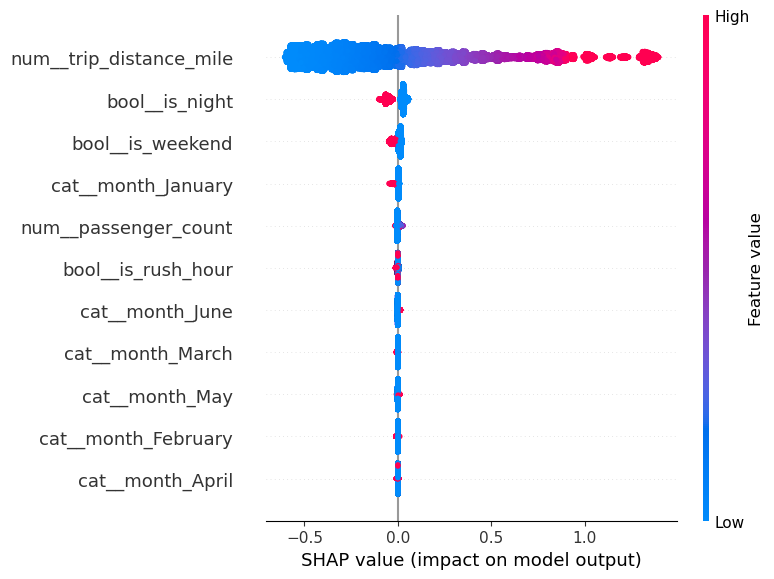

In [77]:
import shap

X_train_processed= preprocessor.fit_transform(X_train)
X_test_processed=preprocessor.transform(X_test)
column_name=preprocessor.get_feature_names_out()

X_test_processed_df = pd.DataFrame(X_test_processed, columns=column_name)

explainer = shap.Explainer(best_model.named_steps["xgb"])
shap_values = explainer(X_test_processed_df)

shap.summary_plot(shap_values, X_test_processed_df)

This SHAP (SHapley Additive Explanations) summary plot shows how each feature impacts the model's predictions.

How to understand this:

x-axis (Impact on Model Output)
Negative values decrease the predicted speaking proficiency.
Positive values increase the predicted speaking proficiency.
y-axis (Model Features)
The order of the features on the Y-axis is based on overall importance.
Color (Feature Value Intensity)
Red → Feature is at its higher range.
Blue → Feature is at its lower range.

# 9. Results <a id="9"></a>

### Main takeaway

The study reveals that trip distance is the strongest predictor of fare amount, while time of day and weekend effects have minimal influence unless combined with trip distance.

Policy recommendations include increasing the availability of small to medium-sized vehicles, as the majority of taxi customers travel alone or with just one additional passenger.

Future work should explore the incorporation of real-time traffic conditions, weather data, and dynamic pricing factors to further enhance fare prediction accuracy and service efficiency.
    


### Conclusions and Business Recommendations

This capstone project analyzed a large dataset of taxi trips to understand the key factors influencing fare amounts and to build a reliable fare prediction model. Through data preprocessing, feature engineering, and model evaluation, several important insights were uncovered.

* Trip distance emerged as the most significant determinant of fare amount, confirming that longer trips directly lead to higher fares.

* Temporal factors such as time of day, day of the week, and weekends showed limited standalone impact on fares but demonstrated interactions with distance — for instance, longer trips during peak hours slightly increased fares.

* The best-performing model (e.g., Gradient Boosting or XGBoost) achieved strong predictive accuracy with minimal bias, as shown by residuals distributed evenly around zero.

* Model diagnostics suggested no major systematic errors, although prediction uncertainty increased slightly for higher fare amounts.

* From a policy and business perspective, the findings support allocating more small to medium-sized vehicles, since most trips involve one or two passengers and shorter distances.

* Fare pricing aligns well with trip distance, validating the current distance-based fare structure. However, monitoring outliers could help identify billing errors or opportunities to refine fare estimation models.

### Future Work

Future research can focus on:

* Integrating real-time traffic, weather, and surge pricing data to improve prediction accuracy.

* Exploring deep learning or ensemble methods to capture complex nonlinear relationships.

* Developing an interactive fare estimation tool for customers and operators to optimize trip planning and resource allocation.